In [ ]:
from langgraph.graph import StateGraph, START , END
from dotenv import load_dotenv
load_dotenv()
from typing import TypedDict,Optional, Annotated,List
from  langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from  langchain_core.prompts import PromptTemplate
from  langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel


In [ ]:
llm = HuggingFaceEndpoint(model="meta-llama/Meta-Llama-3-8B-Instruct",task="text-generation")
model = ChatHuggingFace(llm=llm)

/media/kratos/LocalDiscLinux/langgraph/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from typing import Literal


class TweetState(TypedDict):
    topic: str
    tweet:str
    old_tweet: List[str]
    iteration : int
    max_iteration : int
    feedback : Literal['approved', 'not approved'] | None



In [4]:
def generate_tweet(state: TweetState) ->TweetState:
    topic = state['topic'] 
    
    messages = [
        SystemMessage(content='Make the tweet sharp and short'),
        HumanMessage(content=f'Make a tweet about this topic: {topic}'),
    ]
    
    response = model.invoke(messages)
    
    state['iteration'] += 1 
    if type(response.content)==str:
        state['tweet']=response.content
    return state


In [5]:
class TweetFeedback(BaseModel):
    clarity: int
    brevity : int
    engagement : int
    relevance : int
    overall_score : float
    suggestion : str


In [6]:
def get_feedback(response):
    if response['overall_score'] > 9:
        return 'approved'
    else:
        return 'not approved'

In [7]:
class TweetFeedback(BaseModel):
    clarity: int
    brevity : int
    engagement : int
    relevance : int
    overall_score : float
    suggestion : str

def feedback_tweet(state: TweetState) -> TweetState:
    tweet = state['tweet']

    messages = [
        SystemMessage(content="Rate the tweet from 1–10 on clarity, brevity, engagement, relevance, originality and then overall_score. Return JSON dict only with these keys and there value clarity, brevity, engagement, relevance, originality and then overall_score."),
        HumanMessage(content=f"{tweet}"),
    ]

    response = model.invoke(messages)  

    import json
    feedback_data = json.loads(response.content)
    print(response.content)
    
    state['feedback'] = 'approved' if feedback_data['overall_score'] > 9 else 'not approved'
    return state



In [8]:
def enchanceTweet(state:TweetState)->TweetState:
    tweet = state['tweet'] 
    state['old_tweet'].append(state['tweet'])

    messages = [
        SystemMessage("You are a expert tweeter what you need to do is make the tweet good by these terms clarity, brevity, engagement, relevance, and originality"),
        HumanMessage(content=f'{tweet}'),
    ]

    state['iteration'] = state['iteration'] + 1
    response = model.invoke(messages)
    if type(response.content) == str:
        state['tweet']=response.content

    
    return state

In [9]:
graph = StateGraph(TweetState)


In [10]:
def return_literal(state:TweetState):
    if state['feedback']=='approved' or state['iteration'] > state['max_iteration']:
        return 'approved'
    else:
        return 'not approved'

In [11]:
graph.add_node('generate_tweet',generate_tweet)
graph.add_node('feedback_tweet',feedback_tweet)
graph.add_node('enchanceTweet',enchanceTweet)




graph.add_edge(START,'generate_tweet')
graph.add_edge('generate_tweet','feedback_tweet')
graph.add_conditional_edges('feedback_tweet',return_literal,{
    'approved':END,
    'not approved':"enchanceTweet"
})
graph.add_edge('enchanceTweet','feedback_tweet')


In [12]:
workflow = graph.compile()

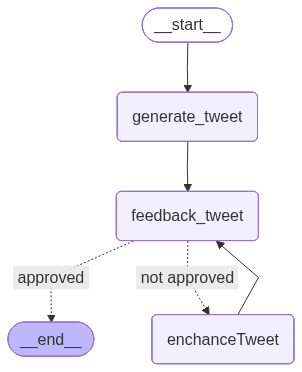

In [13]:
workflow

In [14]:
state: TweetState = {
    'topic': "BJP",
    'max_iteration': 3,
    'iteration': 0,
    'tweet':'',
    'old_tweet':[''],
    'feedback':None
}



In [15]:
result = workflow.invoke(state)


{
  "clarity": 8,
  "brevity": 4,
  "engagement": 6,
  "relevance": 9,
  "originality": 2,
  "overall_score": 5.6
}
{"clarity": 8, "brevity": 6, "engagement": 8, "relevance": 9, "originality": 4, "overall_score": 7.6}
{
  "clarity": 9,
  "brevity": 8,
  "engagement": 8,
  "relevance": 10,
  "originality": 7,
  "overall_score": 8.4
}
{
  "clarity": 8,
  "brevity": 6,
  "engagement": 7,
  "relevance": 9,
  "originality": 4,
  "overall_score": 7.2
}


In [16]:
result

{'topic': 'BJP',
 'tweet': '"Did @BJP\'s \'Make in India\' deliver on its promise? The economic boom is undeniable, but at what cost to social justice, equality & freedom? A complex legacy for India\'s fastest-growing economy. #MakeInIndia #IndiaEconomy"',
 'old_tweet': ['',
  '"India\'s journey under @BJP\'s leadership has been transformative. From economic growth to cultural resurgence, the party\'s policies have had a profound impact on the nation. #BJP #India"',
  '"Beneath the BJP\'s leadership, India\'s trajectory has been nothing short of remarkable. Economic growth, cultural revival & a national resurgence - has the party truly transformed the nation? #BJP #India"',
  '"Has @BJP\'s \'Make in India\' vision created a new India? The numbers say yes, but the questions on social justice, equality & freedom remain. Has the party delivered on its promise? #BJP #India"'],
 'iteration': 4,
 'max_iteration': 3,
 'feedback': 'not approved'}